# 02 — Train, Predict, Evaluate  
## From Data to a First Machine Learning Model

In this notebook, we will:
- split data into **train** and **test**
- train a machine learning model
- make predictions
- evaluate how well the model performs

This is our **first complete ML workflow**.


## 1️⃣ Reminder: What Do We Already Have?

From the previous notebook:
- `X` → inputs (customer information)
- `y` → output (churn: Yes / No)

Now we want to:
> teach a model using part of this data  
> and test it using **new, unseen data**


In [2]:
import pandas as pd

# Load the dataset again 
df = pd.read_csv("data/churn_cleaned.csv")

# Separate inputs and output
X = df.drop(columns=["Churn"])
y = df["Churn"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6990, 11)
y shape: (6990,)


## 2️⃣ Why Do We Split the Data?

If we train and test on the **same data**:
- the model may just memorize
- evaluation would be misleading

### Solution:
We split the data into:
- **Training set** → used to learn patterns
- **Test set** → used only to evaluate

The test set simulates **new customers**.


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% for testing
    random_state=42,    # for reproducibility (every time we run the code, we get the same split)
    stratify=y          # to maintain the same distribution of classes in train and test sets
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Training samples: 5592
Test samples: 1398


## 3️⃣ What Is a Machine Learning Pipeline?

A pipeline is a **sequence of steps**.

In our case:
1. Prepare the data (numbers + categories)
2. Train a model

Why pipelines are useful:
- no forgotten steps
- same logic during training and prediction
- perfect for saving and reusing later


In [ ]:
# We will use scikit-learn to build the pipeline (Data Preparation + Model)

from sklearn.compose import ColumnTransformer           # for handling different types of features
from sklearn.pipeline import Pipeline                   # for creating a pipeline (Data Preparation + Model)
from sklearn.preprocessing import OneHotEncoder         # for handling categorical features
from sklearn.preprocessing import StandardScaler        # for handling numerical features
from sklearn.linear_model import LogisticRegression     # our model

In [5]:
# Identify feature types
categorical_features = X.select_dtypes(include="object").columns
numeric_features = X.select_dtypes(exclude="object").columns

print("Categorical features:", list(categorical_features))
print("Numeric features:", list(numeric_features))

Categorical features: ['gender', 'Partner', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']
Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [6]:
# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),  # Convert categorical features to numeric 
        ("num", StandardScaler(), numeric_features),  # Scale numeric features for better model performance
    ]
)

# Full pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

But, Give me a simple intuition about all of this!

* Machine Learning Model needs numbers to learn patterns, so we convert categories to numbers.

    We use here a technique called `One-Hot Encoding` to do that.

* Also, some features have very different scales (e.g., `tenure` ranges from 0 to 72, while `MonthlyCharges` ranges from 18.25 to 118.75).

    So, we use a technique called `Standard Scaling` to bring all numeric features to a similar scale.

* Finally, we use a machine learning algorithm called `Logistic Regression` to learn from the data and make predictions about customer churn.


## 4️⃣ Training the Model

When we call `.fit()`:
- the model looks at **inputs**
- compares them to **known outcomes**
- learns patterns that best separate churn vs non-churn

This is supervised learning.


In [ ]:
# Train the pipeline (Applying the steps sequentially)
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

## 5️⃣ Making Predictions

After training, the model can:
- predict **Yes / No** (churn or not)
- estimate a **probability of churn**

We will look at both.


In [12]:
# Class predictions
y_pred = pipeline.predict(X_test)

# Probability predictions
y_proba = pipeline.predict_proba(X_test)

y_pred[:5], y_proba[:5][:, 1]  # Probability of positive class


(array(['No', 'Yes', 'Yes', 'No', 'No'], dtype=object),
 array([0.0618298 , 0.67955446, 0.57090534, 0.04594068, 0.02805936]))

## 6️⃣ Accuracy 

⚠️ Accuracy alone can be misleading  
We will still start with it for simplicity.


In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7954220314735336

## 7️⃣ Looking Beyond Accuracy

The following figure shows a confusion matrix which breaks down predictions into:
- correct predictions
- wrong predictions
- *what kind* of mistakes the model makes

This helps us understand model behavior.

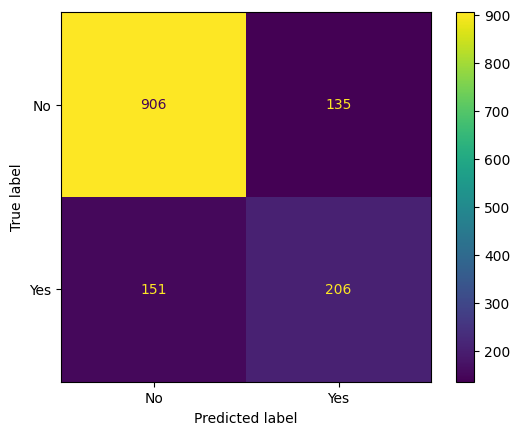

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Confusion Matrix Breakdown:
* We already have *357* actual churners.
* The model correctly identified *206* of them (`True Positives`).
* It missed *151* churners (`False Negatives`).
* Out of *1041* non-churners, it correctly identified *906* (`True Negatives`).
* It incorrectly labeled *135* non-churners as churners (`False Positives`).

## 8️⃣ Save the trained pipeline (one file)

We will save **one file** that contains:
- preprocessing steps
- trained model

So we can reuse it later in the web app without retraining.


In [ ]:
from pathlib import Path
import joblib  # for saving and loading the model in binary format

# Create model directory if it doesn't exist
Path("model").mkdir(exist_ok=True)

# Save the model
joblib.dump(pipeline, "model/churn_pipeline.joblib")
print("Saved: model/churn_pipeline.joblib")

Saved: model/churn_pipeline.joblib


## ✅ What We Learned in This Notebook 
 
- Why we split data into train and test (fair evaluation)
- How a pipeline works (preprocessing + model together)
- How a model is trained using `.fit()`
- How predictions are made (`predict` + `predict_proba`)
- How to evaluate using accuracy (and what accuracy does *not* tell us)

✅ We also saved the trained pipeline to:
- `model/churn_pipeline.joblib`

➡️ Next : Go to `03_use_model_and_predict.ipynb` to learn how to load the saved pipeline and make predictions for new customers.